In [1]:
### he we compare CHiCAGO calls at fragment and 5kb (solitary baits) resolution
### Fig. 1 data for panels B,C,D

library(Chicago)
library(cowplot)
library(tidyr)
library(ggplot2)

## loading ILC Chicago results
ilc_fres <- readRDS("~/miniPCHiC/hILCs/hILCs_run2/Chicago/without_binning/hILC3_all_merged_Step2_corrected_weighting/data/hILC3_all_merged_Step2_corrected_weighting.Rds")
ilc_5kb <- readRDS("~/miniPCHiC/hILCs/hILCs_run2/Chicago/with_binning/hILCs_all_merged_bin_Step2/data/hILCs_all_merged_bin_Step2.Rds")

## loading rmaps
rmap_fres <- fread("/rds/general/user/malyshev/home/spivakov_analysis_live/Design/Human_DpnII_binsize1500_maxL75K/hg38_dpnII.rmap")
rmap_5kb <- fread("/rds/general/user/malyshev/home/spivakov_analysis_live/Design/Human_hg38_bin5K_sol_baits/human_DpnII_5K_sol_baits.rmap")

## loading bmaps
bmap_fres <- fread("/rds/general/user/malyshev/home/spivakov_analysis_live/Design/Human_DpnII_binsize1500_maxL75K/hg38_dpnII.baitmap")
bmap_5kb <- fread("/rds/general/user/malyshev/home/spivakov_analysis_live/Design/Human_hg38_bin5K_sol_baits/human_DpnII_5K_sol_baits.baitmap")


Warning message:
“package ‘Chicago’ was built under R version 3.6.3”
Loading required package: data.table

Warning message:
“replacing previous import ‘vctrs::data_frame’ by ‘tibble::data_frame’ when loading ‘dplyr’”


Welcome to CHiCAGO - version 1.14.0

If you are new to CHiCAGO, please consider reading the vignette through the command: vignette("Chicago").

NOTE: Default values of tlb.minProxOEPerBin and tlb.minProxB2BPerBin changed as of Version 1.1.5. No action is required unless you specified non-default values, or wish to re-run the pipeline on old chicagoData objects. See news(package="Chicago")



In [2]:
## number of interactions with score > 5

## for ILC3s
nrow(ilc_fres@x[score>5]) # 31003
nrow(ilc_5kb@x[score>5]) # 58632


[1] 31003

[1] 58632

Warning message in FUN(X[[i]], ...):
“NaNs produced”
Warning message:
“Removed 43771 rows containing non-finite values (stat_density).”


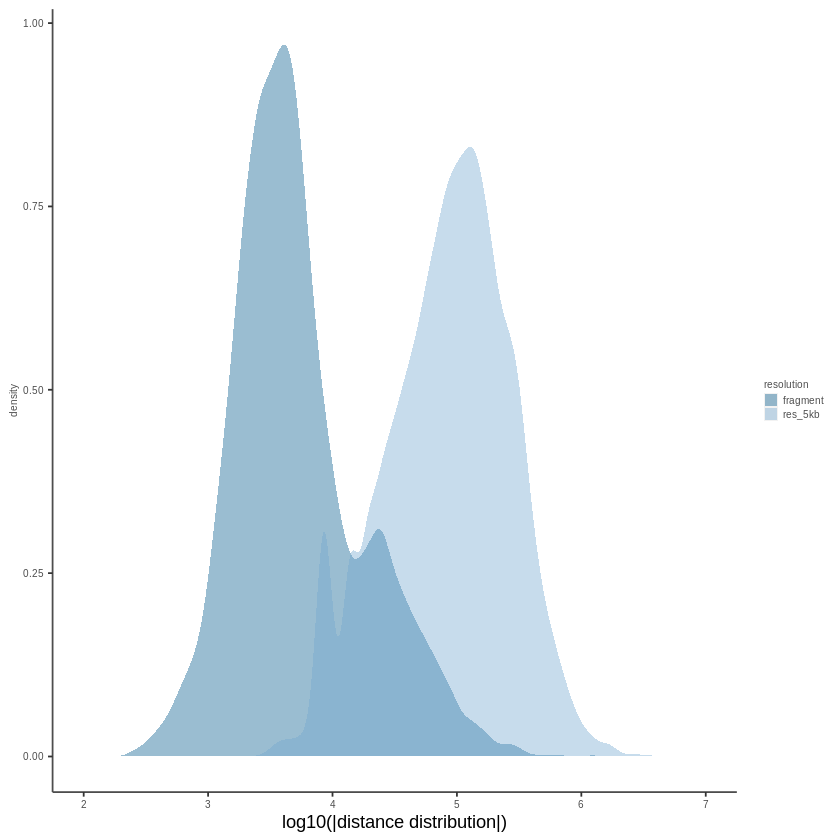

In [3]:
### distance comparison

distance_bundle <- rbind(ilc_fres@x[score>=5][,c("distSign")][,resolution := "fragment"], 
                         ilc_5kb@x[score>=5][,c("distSign")][,resolution := "res_5kb"]) 

distance_bundle <- distance_bundle[!is.na(distSign)]

distance_bundle$resolution <- factor(distance_bundle$resolution, 
                                     levels = c("fragment", 'res_5kb'))  
  
p <- ggplot(data=distance_bundle, aes(x=(log(distSign, 10)), group=resolution, fill = resolution)) +
        geom_density(alpha=.4, colour=NA) +
        xlim(2,7) + 
        scale_fill_manual(values = c("fragment" = "#045a8d",
                                           "res_5kb"="#74a9cf")) + 
        theme(axis.text.x = element_text(size = 6),
            axis.text.y = element_text(size = 6),
            axis.title.y = element_text(size = 6, colour = "grey30"),
            legend.title = element_text(size=6, colour = "grey30"),
            legend.text = element_text(size=6, colour = "grey30"),
            legend.key.width = unit(0.3, 'cm'),
            legend.key.height = unit(0.3, 'cm'),
            panel.background = element_rect(fill = "white"),
            axis.line.x=element_line(color="grey30"),
            axis.line.y=element_line(color="grey30")
            ) +
        ylab("density") +
        xlab("log10(|distance distribution|)")
  
p

In [6]:
## create consensus between resolutions
# if a higher resolution interaction exists within a lower resolution interaction (i.e. fres one within 5kb)
# then only a higher resolution interaction is retained (i.e. fres)

### merging rmaps
### assign fragment-res IDs to 5kb-res IDs by the summit of fragment-res

rmap_fres[,mid1 := (V2+V3)/2]
rmap_fres[,mid2 := (V2+V3)/2+1]


setkey(rmap_fres, V1, mid1, mid2)
setkey(rmap_5kb, V1, V2, V3)

rmap_fres_5kb <- foverlaps(rmap_fres, rmap_5kb, by.x = c("V1", "mid1", "mid2"), by.y = c("V1", "V2", "V3"), type = "within")

colnames(rmap_fres_5kb) <- c("chr", "start_5kb", "end_5kb", "baitID_5kb", 
                             "start_fres", "end_fres", "baitID_fres", "mid1", "mid2")


ilc_fres_sel <- merge(ilc_fres@x[score>=5], rmap_fres_5kb[,c("baitID_fres", "baitID_5kb")], by.x = c("baitID"), by.y = c("baitID_fres"))
ilc_fres_sel <- merge(ilc_fres_sel, rmap_fres_5kb[,c("baitID_fres", "baitID_5kb")], by.x = c("otherEndID"), by.y = c("baitID_fres"))
ilc_fres_sel[,contactID_5kb := paste0(baitID_5kb.x, "_", baitID_5kb.y)]

ilc_5kb_sel <- ilc_5kb@x[score>=5]
ilc_5kb_sel[,contactID_5kb := paste0(baitID, "_", otherEndID)]
ilc_5kb_sel[,is_in_fres := ifelse((contactID_5kb %in% ilc_fres_sel$contactID_5kb), "TRUE", "FALSE")]

table(ilc_5kb_sel$is_in_fres)



FALSE  TRUE 
53645  4987 

In [7]:
total_int <- nrow(ilc_5kb@x[score>=5]) + nrow(ilc_fres@x[score>=5]) 
print(total_int) 
total_nonred <- nrow(ilc_5kb_sel[is_in_fres == "FALSE"]) + nrow(ilc_fres_sel) 
print(total_nonred)

[1] 89635
[1] 84648


In [8]:
### plotting selected genes

ggplotBait <- function(cd, bait = NULL, left = NULL, right = NULL, ymax = NULL){
  rmap <- fread(cd@settings$rmapfile)
  bmap <- fread(cd@settings$baitmapfile)
  dat <- cd@x
  disp <- cd@params$dispersion
  if(is.null(bait)){
    bait <- sample(unique(dat$baitID),1)
  }
  dat <- cd@x[baitID == bait & !is.na(distSign)]
  dat <- merge(dat, rmap, by.x = c("otherEndID"), by.y = c("V4"))
  dat[,oeID_av:=(V2+V3)/2000] # also convert to kb scale by dividing by 1000
  midpoint <- (rmap[V4==bait]$V2+rmap[V4==bait]$V2)/2000 # also convert to kb scale by dividing by 1000
  limits <- c(midpoint-left, midpoint+right)
  
  color <- ifelse(dat$score>5, "red", ifelse(dat$score>3 & dat$score<5, "blue", "black"))
  shap <- ifelse(dat$score>3, 19, 21)
  p1 <- ggplot(dat, aes(oeID_av, N)) +
    geom_point(aes(colour = color, shape = shap), size = 0.5) + 
    xlim(limits) +
    ylim(0,ymax) +
    scale_color_identity() +
    scale_shape_identity() +
    geom_line(aes(y = Bmean), color = "grey45") +
    geom_line(linetype = "dashed", aes(y = Bmean+1.96*sqrt(Bmean+Bmean^2/disp)), color = "grey65")+
    ylab(label = "PCHiC read count") +
    xlab(label = NULL) +
    ggtitle(paste0(bmap[V4==bait]$V5," (", bait, ")")) +
    geom_vline(xintercept = midpoint, color = "grey65") +
    theme_minimal()+
    theme(panel.grid.minor = element_blank(),
          panel.grid.major.x = element_blank(),
          panel.grid.major.y = element_line("grey90", size = 0.2),
          axis.ticks.x.bottom = element_line("grey45"),
          axis.text.x = element_blank(),
          axis.text.x.bottom = element_text(),
          axis.text.y= element_text(),
          axis.title.y= element_text())
  return(p1)
}

ggarcBait <- function(cd, bait = NULL, left = NULL, right = NULL){
  rmap <- fread(cd@settings$rmapfile)
  dat <- cd@x
  disp <- cd@params$dispersion
  if(is.null(bait)){
    bait <- sample(unique(dat$baitID),1)
  }
  dat <- cd@x[baitID == bait & !is.na(distSign) & score >=5]
  dat <- merge(dat, rmap, by.x = c("otherEndID"), by.y = c("V4"))
  dat[,oeID_av:=(V2+V3)/2000] # also convert to kb scale by dividing by 1000
  midpoint <- (rmap[V4==bait]$V2+rmap[V4==bait]$V2)/2000 # also convert to kb scale by dividing by 1000
  limits <- c(midpoint-left, midpoint+right)
  
  color <- ifelse(dat$score>5, "NA", ifelse(dat$score>3 & dat$score<5, "blue", "black"))
  shap <- ifelse(dat$score>3, 19, 21)
  p3 <- ggplot(dat, aes(oeID_av, 0)) +
    geom_point(aes(colour = color, shape = shap)) + 
    xlim(limits) +
    ylim(-2,0) +
    xlab(label = NULL) +
    scale_color_identity() +
    scale_shape_identity() +
    theme_minimal()+
    ylab(label = NULL) +
    theme(legend.position = "bottom",
          panel.grid = element_blank(),
          axis.text.x = element_blank(),
          axis.text.y = element_blank())
  
  
  for (i in row.names(dat)){
    p3 <- p3 + if(dat[as.numeric(i)]$oeID_av < midpoint){
      geom_curve(aes(x = midpoint, y = 0, xend = oeID_av, yend = 0, colour = "red"), curvature = -0.5, data = dat[as.numeric(i)])
    }else{
      geom_curve(aes(x = midpoint, y = 0, xend = oeID_av, yend = 0, colour = "red"), curvature = 0.5, data = dat[as.numeric(i)])
    }
                       
  }
  return(p3)
}



In [10]:
## SMYD baitID 497126 (fragment resolution) and 40003 (5kb resolution with solitary baits)

chicplot_fres <- ggplotBait(ilc_fres, bait = 497126, 200, 400, 20)
arcplot_fres <- ggarcBait(ilc_fres, bait = 497126, 200, 400)

chicplot_5kb <- ggplotBait(ilc_5kb, bait = 40003, 200, 400, 50)
arcplot_5kb <- ggarcBait(ilc_5kb, bait = 40003, 200, 400)

d <- plot_grid(chicplot_fres, arcplot_fres, chicplot_5kb, arcplot_5kb,
               ncol = 1, align = "v", 
                       rel_heights = c(4, 1.2, 4, 1.2))



Warning message:
“Removed 1348 rows containing missing values (geom_point).”
Warning message:
“Removed 1348 row(s) containing missing values (geom_path).”
Warning message:
“Removed 1348 row(s) containing missing values (geom_path).”
Warning message:
“Removed 1407 rows containing missing values (geom_point).”
Warning message:
“Removed 1407 row(s) containing missing values (geom_path).”
Warning message:
“Removed 1407 row(s) containing missing values (geom_path).”


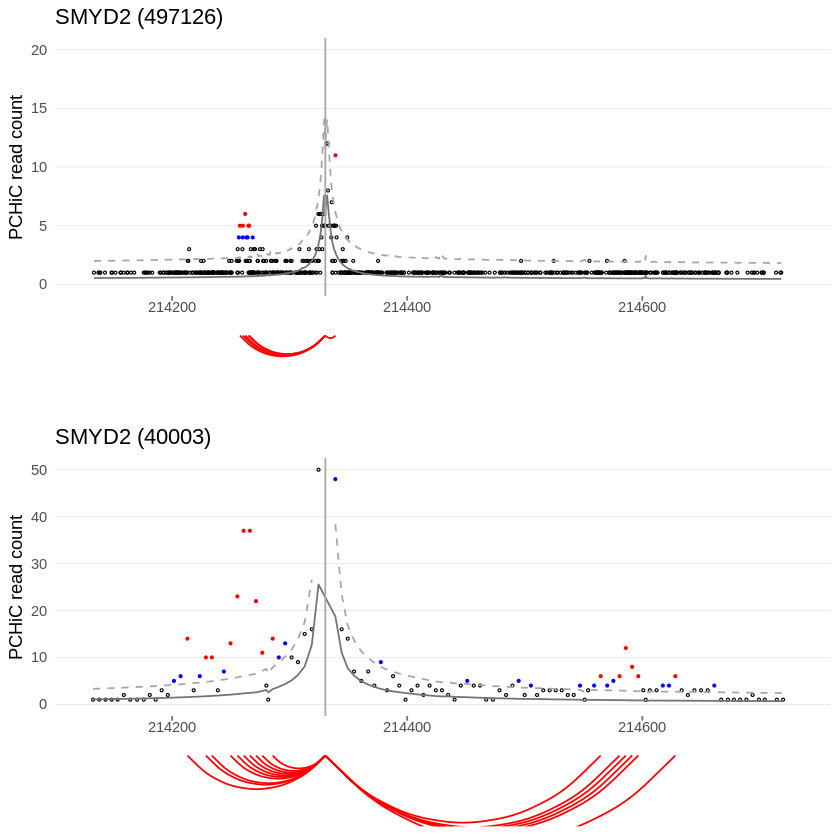

In [11]:
d